In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort
from albumentations.pytorch import ToTensorV2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")

In [2]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/answer.csv", header=None)
df.columns = ['file','target']
print("Target ### Total:  {}".format(len(df)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
Target ### Total:  1242


In [3]:
df_train = pd.DataFrame()
df_train['image_path'] = images_train
df_train['target'] = df['target']
df_train['dataset']  = 'solafune'

In [4]:
df_train.head()

,image_path,target,dataset
0,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
1,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
2,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
3,/home/sebastien/Documents/projects/solafune-fi...,1,solafune
4,/home/sebastien/Documents/projects/solafune-fi...,0,solafune


In [98]:
def data_augmentation(image, verbose=False):

    optical_transform = A.Compose([
    A.HorizontalFlip(p=random.uniform(0, 1)),
    A.VerticalFlip(p=random.uniform(0, 1)),
    A.RandomBrightnessContrast(p=random.uniform(0, 1)),
    A.RandomGamma(p=random.uniform(0, 1)),
    # A.GaussNoise(p=random.uniform(0, 1)),
    A.ColorJitter(p=random.uniform(0, 1))])
    
    apply_transform = ["yes", "no"]
    if random.choice(apply_transform)=="yes":
        augmented = optical_transform(image=image)
        aug_image = augmented['image']

        transform_info = optical_transform.get_dict_with_id()
        
        print("Applied transformations:")
        for key, value in transform_info.items():
            print(f"{key}: {value}")
    else:
        aug_image = image
        
    if verbose:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(image)
        ax1.set_title("Image")
        ax1.axis('off')
        ax2.imshow(aug_image)
        ax2.set_title("Augmented Image")
        ax2.axis('off')
    return aug_image

In [99]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))
def image_preprocessing(image_path):

    image = xr.open_rasterio(image_path, masked=False).values
    
def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    
    
    return rgb_composite_n

In [100]:
img_path = df_train.image_path.iloc[60]

image = image_preprocessing(img_path)
image.shape

(512, 512, 3)

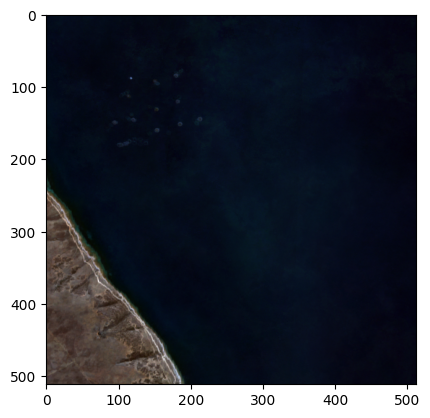

In [101]:
plt.imshow(image)

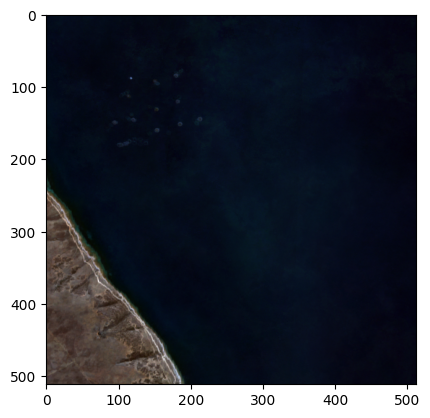

In [113]:
aug = data_augmentation(image)
plt.imshow(aug)

## NDVI , NDWI , NDBI 


In [163]:
def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    NDWI = (image[2,:,:]-image[7,:,:])/(image[2,:,:]+image[7,:,:])
    NDWI = normalize(NDWI)

    NDVI = (image[7,:,:]-image[3,:,:])/(image[7,:,:]+image[3,:,:])
    NDVI = normalize(NDVI)

    MSI = image[10,:,:]/image[7,:,:]
    MSI = normalize(MSI)

    NDBI = (image[10,:,:]-image[7,:,:])/(image[10,:,:]+image[7,:,:])
    
    
    return NDWI, NDVI, MSI, NDBI

In [121]:
nwdi, ndvi, msi, ndbi  = image_preprocessing(img_path)

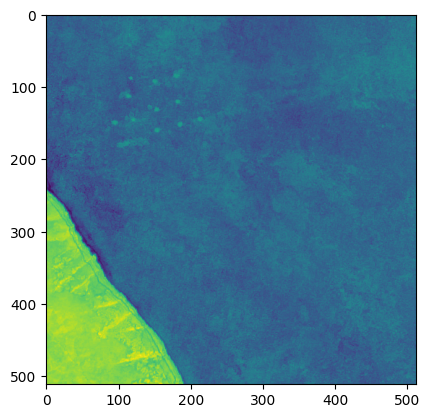

In [122]:
plt.imshow(ndvi)

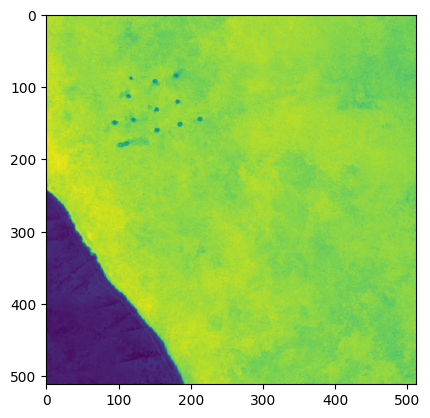

In [123]:
plt.imshow(nwdi)

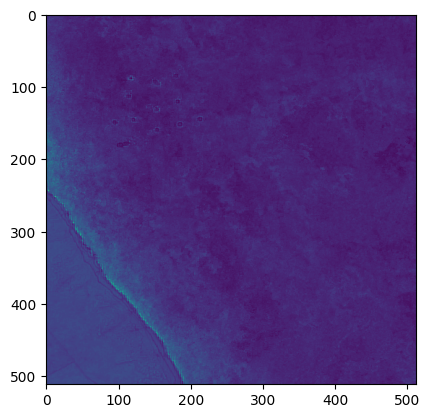

In [124]:
plt.imshow(msi)

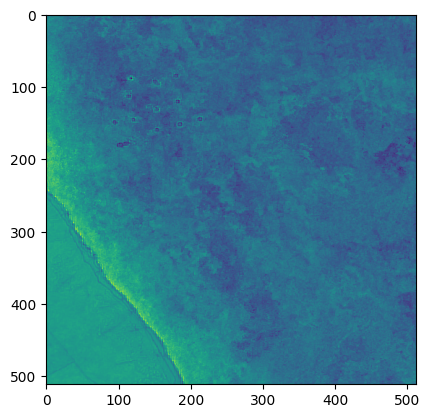

In [125]:
plt.imshow(ndbi)

In [126]:
def image_preprocessing_index(image_path):

    image = xr.open_rasterio(image_path, masked=False).values
    nwdi = (image[2,:,:]-image[7,:,:])/(image[2,:,:]+image[7,:,:])
    nwdi = normalize(nwdi)

    ndvi = (image[7,:,:]-image[3,:,:])/(image[7,:,:]+image[3,:,:])
    ndvi = normalize(ndvi)

    msi = image[10,:,:]/image[7,:,:]
    msi = normalize(msi)

    image_index = np.dstack((ndvi, nwdi, msi))
    
    
    return image_index

(512, 512, 3)

In [127]:
image_index[:,:,0]

array([[0.9279138 , 0.92359346, 0.92142975, ..., 0.87719506, 0.88412035,
        0.88065857],
       [0.91740185, 0.9299504 , 0.9297922 , ..., 0.90460473, 0.86382806,
        0.88383275],
       [0.9051943 , 0.92221314, 0.91754466, ..., 0.9062283 , 0.85039043,
        0.87746584],
       ...,
       [0.937036  , 0.9395943 , 0.9250065 , ..., 0.95231843, 0.943749  ,
        0.93940777],
       [0.9326221 , 0.9439042 , 0.9311139 , ..., 0.9501568 , 0.9498808 ,
        0.9540128 ],
       [0.9247528 , 0.9323355 , 0.9407909 , ..., 0.9582092 , 0.9585493 ,
        0.9595809 ]], dtype=float32)

In [128]:
ndvi

array([[0.25624338, 0.2629421 , 0.36501676, ..., 0.39066908, 0.40919816,
        0.3987525 ],
       [0.3305203 , 0.33216208, 0.32421878, ..., 0.42710313, 0.41544768,
        0.40270618],
       [0.34483892, 0.28683364, 0.3127697 , ..., 0.39910275, 0.41112775,
        0.34982795],
       ...,
       [0.863114  , 0.8417555 , 0.8417555 , ..., 0.32007626, 0.34642053,
        0.34255126],
       [0.86653733, 0.85145575, 0.85145575, ..., 0.2515014 , 0.3619605 ,
        0.3661022 ],
       [0.863655  , 0.857806  , 0.857806  , ..., 0.36559302, 0.39985758,
        0.36438188]], dtype=float32)

In [156]:
from sklearn.decomposition import PCA
# Apply PCA
image = rxr.open_rasterio(img_path, masked=False).values
# Reshape the data to have one row per pixel
reshaped_data = image.reshape((12, -1)).T  # Transpose for the correct shape

# Apply PCA
n_components = 3  # Number of principal components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(reshaped_data)

# Reshape the result back to the original shape
pca_result_reshaped = pca_result.T.reshape((n_components, 512, 512))

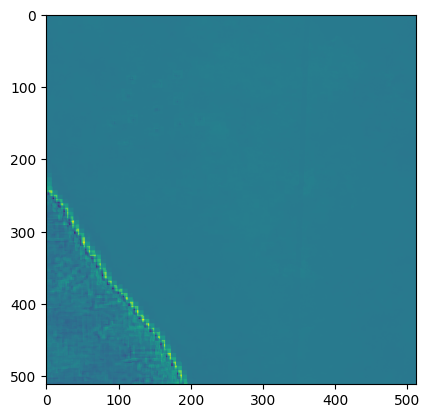

In [157]:
plt.imshow(pca_result_reshaped[2,:,:])

In [158]:
def image_preprocessing_pca(image_path):

    
    from sklearn.decomposition import PCA


    image = rxr.open_rasterio(image_path, masked=False).values
    reshaped_data = image.reshape((12, -1)).T  # Transpose for the correct shape

    n_components = 3  # Number of principal components
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_data)

    pca_result_reshaped = pca_result.T.reshape((n_components, 512, 512))
    pca_result_reshaped = normalize(pca_result_reshaped)
    return pca_result_reshaped

In [159]:
pcs = image_preprocessing_pca(img_path)

In [160]:
pcs.shape

(3, 512, 512)

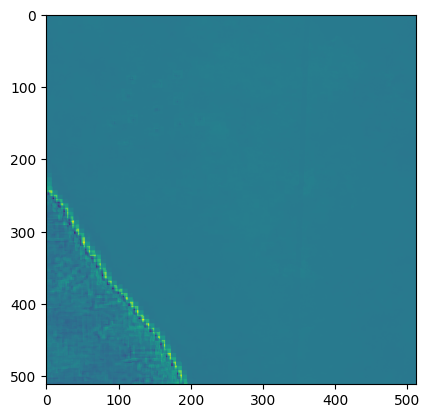

In [152]:
plt.imshow(pcs[2,:,:])